In [1]:
import cv2
import easyocr
import numpy as np
from src.inferencia import inferencia
from collections import Counter

In [2]:

def cortar_placa(frame, bounding_box):
    x_min, y_min, x_max, y_max = map(int, bounding_box)
    return frame[y_min:y_max, x_min:x_max]


def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarização usando método de Otsu
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # GaussianBlur
    blurred = cv2.GaussianBlur(binary, (3, 3), 0)

    width = 800
    height = int(blurred.shape[0] * (width / blurred.shape[1]))
    resized = cv2.resize(blurred, (width, height))

    # Aplicando dilatação e erosão
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(resized, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    # Ajuste de contraste
    contrast_enhanced = cv2.convertScaleAbs(eroded, alpha=1, beta=0)

    return contrast_enhanced

def detectar_caracteres(img, leitor):
    img_preprocessada = preprocess_image(img)
    
    allowlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

    resultado = leitor.readtext(np.array(img_preprocessada), allowlist=allowlist)

    texto_detectado = " ".join([res[1] for res in resultado])

    # Verificar se a placa tem 7 caracteres
    if len(texto_detectado) == 7:
        return texto_detectado
    else:
        return None

def atualizar_votacao_caracteres(placa_atual, nova_placa, votos_caracteres):
    for i, caractere in enumerate(nova_placa):
        if i < len(placa_atual):
            votos_caracteres[i].update([caractere])

def formar_placa_por_votacao(votos_caracteres):
    # Obter o caractere mais votado em cada posição, sendo n=1 para obter o mais votado
    return "".join([votos.most_common(1)[0][0] for votos in votos_caracteres])

def detectar_nova_placa(placa_atual, nova_placa):
    # Contar quantos caracteres são diferentes entre as placas
    diferencas = sum([1 for a, b in zip(placa_atual, nova_placa) if a != b])
    return diferencas >= 5  # Se 5 ou mais caracteres forem diferentes, é uma nova placa

Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 object, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 320.0ms postprocess per image at shape (1, 3, 640, 384)


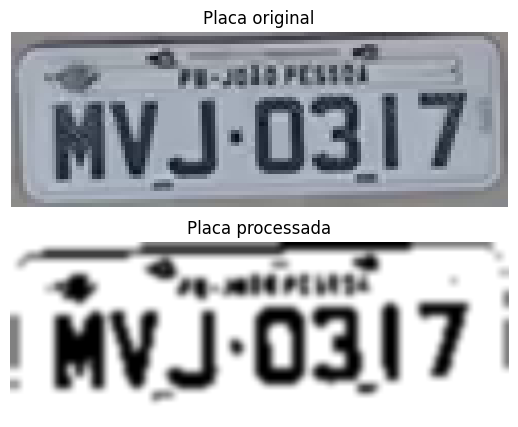

In [4]:
from time import sleep
import matplotlib.pyplot as plt


def processar_video(video_path, gpu=True):

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Erro ao abrir o vídeo: {video_path}")
        return

    leitor = easyocr.Reader(['pt', 'en'], gpu=gpu)

    # Placa atual inferida
    placa_atual = None  
    # Lista de contadores de votos por posição de caractere
    votos_caracteres = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        resultado = inferencia(frame)
        if len(resultado.boxes) > 0:  # Verificar se há alguma placa detectada
            bbox = resultado.boxes.xyxy[0].tolist()

            placa_img = cortar_placa(frame, bbox)
            placa_img_processed = preprocess_image(placa_img)
        
        cv2.imshow('frame', placa_img_processed)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        break

    cap.release()
    cv2.destroyAllWindows()

    # plot as imagens da placa_img e placa_img_processed lado a lado
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(placa_img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(placa_img_processed, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title('Placa original')
    ax[1].set_title('Placa processada')

    # faça o fundo dos plot serem pretos para melhor visualização
    # fig.patch.set_facecolor('black')


    plt.show()

processar_video("organic-data/video_teste_1.mp4", gpu=False)


0: 640x384 1 object, 4.7ms
Speed: 1.1ms preprocess, 4.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


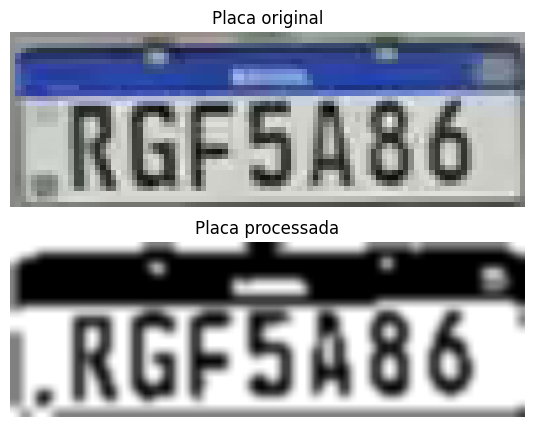

In [5]:
processar_video("organic-data/video_teste_2.mp4", gpu=True)


0: 640x384 2 objects, 3.7ms
Speed: 1.2ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


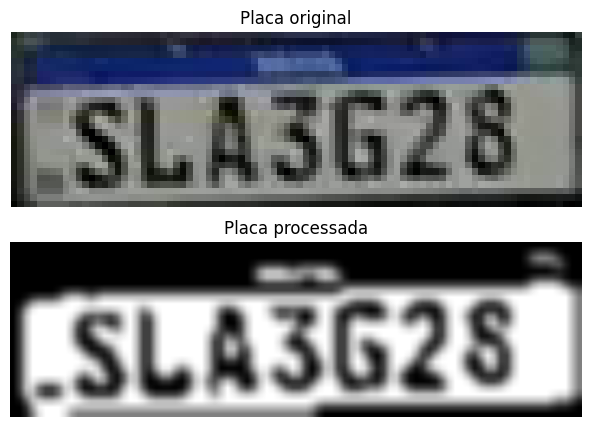

In [6]:
processar_video("organic-data/video_teste_3.mp4", gpu=True)